In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
import scipy.optimize as spo
import feo_thermodynamics

# FeO nucleation

Abandon equation 2 from Davies et al. as we have the ability to calculate $g^{sl}$ explicitly
as a function of T, P and x (given some assumptions about what happens to O, discussed below).
The following is still ok:

$$ \Delta G = 4/3 \pi r^3 g^{sl} + 4 \pi r^2 \gamma,$$

$$ r_c = \frac{-2 \gamma}{g^{sl}}, $$

(negative $r_c$ implies $g^{sl}$ is positive and we are above the liquidus.)

$$ \Delta G_c = \frac{16 \pi \gamma^3}{{3 g^{sl}}^2} $$

and 

$$ I = I_0 \exp \left[\frac{-\Delta G_c}{k_B T}\right] $$

or

$$ \tau_v = \frac{1}{2 I_0} \exp \left[\frac{\Delta G_c}{k_B T}\right] $$

approximations (beyond the thermodynamic model being right) are that the forward
and backwards reaction rates at the top of the barrier are the same, that $\gamma$
can be taken as a constant, that the crystalizing solid can be described by the bulk
thermodynamics, and that the neucli are spherical.

For an FeO liquid we can calculate the energy of solid HCP Fe and a liquid of any
oxygen content. We can then write:

$$g^{sl} = p g^{solid} + q g(x_p)^{liquid} - (p+q) g(x_i)^{liquid} $$

Where $(p+q)$ moles of liquid of composition $x_i$ freeze to form $p$ moles of HCP iron and 
$q$ moles of residual liquid of composition $x_p$. $p$ can be calculated from the volume of the
critical radius and the molar volume of the solid and $x_i$ is known. The difficulty is 
calculating $q$ and $x_p$. Note also that the volume of the solid and the two liquids differ, 
so that we need to include a PV term, but this is already included in the free energy calculation.


## Well mixed approximation

One approach is to say that as the critical nucleus forms the ejected oxygen becomes well mixed
in a macoscopic system. In this case $g(x_p)^{liquid} = g(x_i)^{liquid}$ and:

$$g^{sl} = g^{solid} - g(x_i)^{liquid} $$

In this approach $g(x_i)^{liquid}$ should be the chemical potential of Fe in the liquid (at $x_i$)
so we do not erroniously count the energy of the oxygen. We are essentially counting the energy
difference of the iron atoms in the well mixed liquid and the same atoms in the solid critical nucleus.


The following uses parameters from Davies et al. but thermodynamics from Komabayashi.


In [3]:
def well_mixed_nucleation(gamma, gsl):
    """
    Calculate CNT parameters assuming pure phase or well mixed liquid
    
    gamma: surface energy (J m^-2)
    gsl: difference between free energy of solid and liquid (J m^-3)
    i0: pre-factor / attempt rate (s^-1 m^-3)
    
    if t > melting temperature, returns np.nan
    
    returns critical radii (in m), free energy barrier (in J), 
    nucleation rate (s^-1 m^3), and waiting time (s m^3)
    """
    # rc
    rc = -2*gamma / gsl
    mask = rc<=0.0 # negative radius is > Tm
    rc[mask] = np.nan
    
    # gc
    gc = (16.0 * np.pi * gamma**3) / (3.0 * gsl**2) # in J?
    gc[mask] = np.nan
    
    return rc, gc
    

In [4]:
def nucleation_rate(t, i0, gc):
    """
    Calculate nucleation rate for CNT given free energy at critical radius
    
    t: temperature (in K)
    i0: pre-factor / attempt rate (s^-1 m^-3)
    gc: free energy of critical radius (J)
    
    returns I (in s^-1 m^-3)
    """
    kb = 1.38064852E-23
    # nuc rate
    i = i0 * np.exp(-gc / (t * kb))
    return i

def waiting_time(t, prefac, gc):
    """
    Calculate waiting time for CNT given free energy at critical radius
    prefac: pre-factor / attempt rate (s m^3) [NB: inverse of i0 above!!!]
    gc: free energy of critical radius (J)
    
    returns tauv (in s m3)
    """
    # FIXME: this is likly to overflow in the exp, even if we precompute
    # prefac = 1/(2 i0). Break up the exp bit?
    kb = 1.38064852E-23
    
    # waiting time
    tauv = prefac*np.exp(gc / (t * kb))
    return tauv

In [5]:
def well_mixed_gsl(x, p, t):
    """
    Free energy change when making solid Fe in liquid FeO
    
    Assumes no O in solid, ideal mixing in liquid...
    
    """
    # All in J/mol
    _, g_fe, _ = feo_thermodynamics.solid_free_energies(x, p, t)
    g_lq = feo_thermodynamics.fe_liquid_chemical_potential(x, p, t)
    _, mol_vol_solid, _ = feo_thermodynamics.solid_molar_volume(1.0, p, t)
    _, partial_mol_vol_liquid, _ = feo_thermodynamics.liquid_molar_volume(1.0, p, t)
    g_sl = g_fe - g_lq # J/mol
    
    g_sl = g_sl  / (mol_vol_solid * 1.0E-6) # J / m^3 of solid
    return g_sl

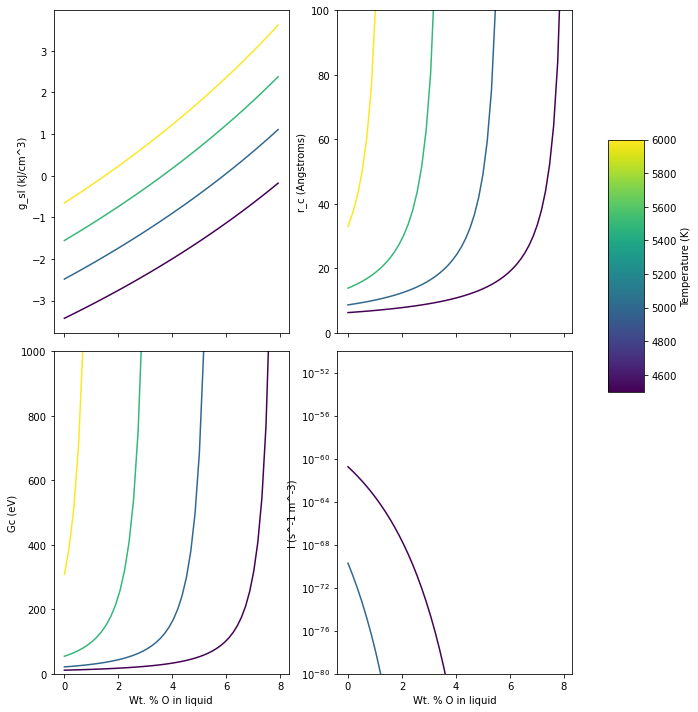

In [6]:
p = 330 # GPa
x = np.linspace(1.0, 0.7) # mol frac Fe
ts = np.array([6000, 5500, 5000, 4500])
gamma = 1.08 # J/m^2
i0 = 0.71E-48 # s^-1 m^-3

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10,10))
cmap=matplotlib.cm.ScalarMappable(cmap='viridis')
cmap.set_clim(vmin=min(ts), vmax=max(ts))


for t in ts:
    
    # g_sl
    g_sl  = well_mixed_gsl(x, p, t)
    
    ax[0,0].plot(feo_thermodynamics.mass_percent_o(x), g_sl/(1000*1.0E6), # kJ/cm^3
            color=cmap.to_rgba(t))

    
    # nuc params
    rc, gc = well_mixed_nucleation(gamma, g_sl)
    i = nucleation_rate(t, i0, gc)

    ax[0,1].plot(feo_thermodynamics.mass_percent_o(x), rc/1E-10,
            color=cmap.to_rgba(t))

    ax[1,0].plot(feo_thermodynamics.mass_percent_o(x), 
               gc*6.242e+18, color=cmap.to_rgba(t))
    
    ax[1,1].plot(feo_thermodynamics.mass_percent_o(x), 
               i, color=cmap.to_rgba(t)) 

ax[0,0].set_ylabel('g_sl (kJ/cm^3)')  
ax[0,1].set_ylabel('r_c (Angstroms)')
ax[0,1].set_ylim(0.0, 100.0)
ax[1,0].set_ylabel('Gc (eV)')
ax[1,0].set_ylim(0.0, 1000.0)

ax[1,1].set_ylabel('I (s^-1 m^-3)')
ax[1,1].set_yscale('log')
ax[1,1].set_ylim(1.0E-80,1.0E-50)
ax[1,0].set_xlabel('Wt. % O in liquid')
ax[1,1].set_xlabel('Wt. % O in liquid')



fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.45, 0.05, 0.35])
cbar = fig.colorbar(cmap, cax=cbar_ax)
cbar.set_label('Temperature (K)')
plt.show()

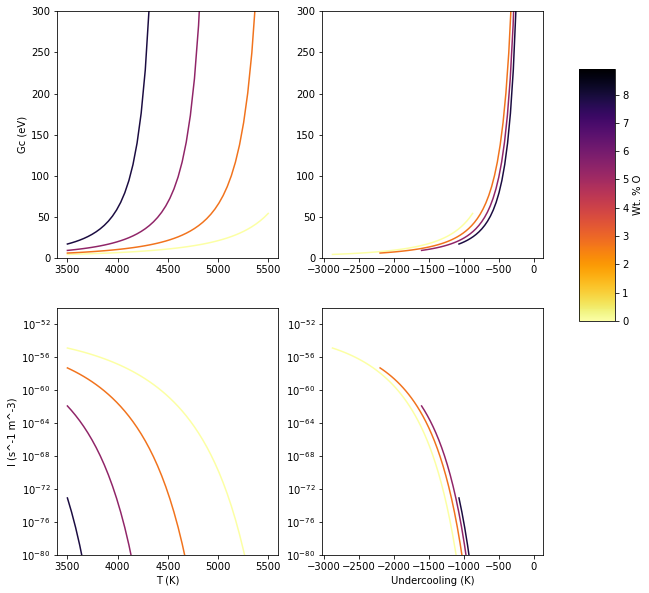

In [7]:
p = 330 # GPa
xs = np.array([1.0, 0.9, 0.8, 0.7]) # mol frac Fe
ts = np.linspace(3500, 5500)
gamma = 1.08 # J/m^2
i0 = 0.71E-48 # s^-1 m^-3

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

cmap=matplotlib.cm.ScalarMappable(cmap='inferno_r')
cmap.set_clim(vmin=feo_thermodynamics.mass_percent_o(max(xs)), vmax=feo_thermodynamics.mass_percent_o(min(xs))+1.0)

for x in xs:
    g_sl = np.zeros_like(ts)
    t_liquidus = feo_thermodynamics.find_liquidus(x, p)
    for i, t in enumerate(ts):
        g_sl[i]  = well_mixed_gsl(x, p, t)
        
    # nuc params
    rc, gc = well_mixed_nucleation(gamma, g_sl) 
    i = nucleation_rate(ts, i0, gc)
    
    ax[0,0].plot(ts, gc*6.242e+18, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    ax[0,1].plot(ts-t_liquidus, gc*6.242e+18, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))

    ax[1,0].plot(ts, 
               i, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    ax[1,1].plot(ts-t_liquidus, 
               i, color=cmap.to_rgba(feo_thermodynamics.mass_percent_o(x)))
    
ax[0,0].set_ylabel('Gc (eV)')
ax[1,0].set_xlabel('T (K)')
ax[0,0].set_ylim(0, 300)
ax[0,1].set_ylim(0, 300)
ax[1,1].set_xlabel('Undercooling (K)')
ax[1,0].set_ylabel('I (s^-1 m^-3)')
ax[1,0].set_ylim(1.0E-80, 1.0E-50)
ax[1,1].set_ylim(1.0E-80,1.0E-50)
ax[1,0].set_yscale('log')
ax[1,1].set_yscale('log')


#fig.tight_layout()
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.45, 0.05, 0.35])
cbar = fig.colorbar(cmap, cax=cbar_ax)
cbar.set_label('Wt. % O')
plt.show()

**Conclusions:**

* We can have a model of nucleation that is self consistent with the thermodynamic model
and includes the effect of oxygen in the liquid.

* In the 'well mixed' case at fixed temperature adding oxygen to the liquid means the undercooling
is smaller, and so the barrier to nucleation grows. This is what is expected from the melting point
depression and accords with the results presented in Davies et al.

* In principle there is an additional effect - iron in the liquid iron-oxygen mixture is less 
stable than iron in pure iron liquid (the $\ln(x)$ term in the chemical potential). This
lowers the barrier to nucleation but this is a very small effect once the melting point
depression has been accounted for.

## Restricted volume

Alternitivly, we can imagine a small volume of liquid around the nucleus (say the radius of 
chemical fluctuations in the supercooled liquid) with the total oxygen confined within this region.
In this case we can calculate $(p + q)$ from the radius of the confinment region and $x_p$ from the
need to conserve the total oxygen content. For some radius, $x_i$ will happen to be equal to the
equilibrium oxygen content for the pressure and temperature. This may (possibly) give the minimum
$g^{sl}$ and thus the smallest $r_c$.

The challange here is that $g^{sl}$ is now a function of the radius of the nucleus. This means we
need to find the critical radius (and critical free energy change) numerically. Otherwise we "just"
need one more parameter (the total volume at the start) but we can probably approximate this from
the O self diffusion rate in the liquid.

We need to worry (a bit) about the volume (or pressure) of the system changing as we make solid
and put more O in the liquid. We can deal with this by working in moles and assuming the pressure
is maintained by the surroundings. 

Note - there are actually two ways of thinking about this, as nucleation with fixed composition in
a fixed limited volume, or as a distance around the nucleus that the oxygen can escape to. The code
below implements the first case. I think this is probably more physically realistic (the volume represents
some fluctuation length scale in the liquid) but the code could also be used to implement the second case.
Just set rtot as r + delta r (where deltar is the diffusion lenght or something). The key difference is that
the r+delta r approach will have a big effect for small r and a relativly small effect for big r, while 
the fixed box size approach has an increasing effect as r increases. 

In [8]:
def delta_g_restrictd_volume(r, x, p, t, gamma, rtot):
    """
    Find change in free energy when solid Fe forms in a confined volume
    
    r: radius of solid particle (m)
    x: initial Fe content of liquid (mol frac)
    p: presusre (GPa)
    t: temperature (K)
    gamma: surface energy (j/m^2)
    rtot: radius of confinement region (m)
    
    Finds change in free energy from phase change (i.e. g_sl)
    when a pure Fe particle of radius r forms inside a spherical
    volume of radius rtot with initial composition x accounting for
    the decrease in x in the residual liquid. Adds the
    surface energy. 
    
    returns delta_g, g_bulk_change, g_surface (all in J) and the composition
    of the residual liquid (mol frac Fe)
    """
    total_volume = 4.0/3.0*np.pi*rtot**3
    mol_volume_before, _, _ = feo_thermodynamics.liquid_molar_volume(x, p, t)  # cm^3/mol
    mol_volume_before = mol_volume_before * 1.0E-6 # m^3/mol
    mol_before = total_volume / mol_volume_before
    mol_fe_before = mol_before * x
    mol_o_before = mol_before * (1.0 - x)
    solid_volume = 4.0/3.0*np.pi*r**3
    mol_volume_solid, _, _ = feo_thermodynamics.solid_molar_volume(1.0, p, t)
    mol_volume_solid = mol_volume_solid * 1.0E-6
    mol_solid = solid_volume / mol_volume_solid
    mol_fe_after = mol_fe_before - mol_solid
    mol_lq_after = mol_fe_after + mol_o_before
    x_lq_after = mol_fe_after / (mol_fe_after + mol_o_before)
    

    g_solid, _, _ = feo_thermodynamics.solid_free_energies(1.0, p, t) # J/mol
    g_solid = mol_solid * g_solid # J

    g_liquid_after  = feo_thermodynamics.liquid_free_energies(x_lq_after, p, t)
    g_liquid_after = mol_lq_after * g_liquid_after
    
    g_liquid_before = feo_thermodynamics.liquid_free_energies(x, p, t)
    g_liquid_before = mol_before * g_liquid_before
    
    g_bulk_change = g_solid + g_liquid_after - g_liquid_before
    
    g_surface = 4.0 * np.pi * r**2 * gamma
    
    delta_g = g_bulk_change + g_surface
    return delta_g, g_bulk_change, g_surface, x_lq_after
    

In [9]:
def _delta_g_restrictd_volume(r, x, p, t, gamma, rtot):
    """
    Helper function - returns negative of change in fee energy
    """
    neg_dg = -1.0 * delta_g_restrictd_volume(r, x, p, t, gamma, rtot)[0]
    return neg_dg

def restricted_nucleation(x, p, t, gamma, rtot):
    """
    Find the critical radius and barrier for CNT in a confined volume
    
    x: initial Fe content of liquid (mol frac)
    p: presusre (GPa)
    t: temperature (K)
    gamma: surface energy (j/m^2)
    rtot: radius of confinement region (m)
    
    Finds maximim of free energy by bounded 1D optimisation. Bounds
    are set between 1.0 and 200.0 angstrongs. rtot must be > 200 angstroms.
    
    returns rc (in m), gc (in J) and the composition of the residual liquid (mol frac fe)
    """
    res = spo.minimize_scalar(_delta_g_restrictd_volume, method='Bounded', options={'xatol': 1.0E-11},
                              bounds=(1.0E-10, 200.0E-10), args=(x, p, t, gamma, rtot))
    rc = res.x
    gc, _, _, xc = delta_g_restrictd_volume(rc, x, p, t, gamma, rtot)
    return rc, gc, xc

In [10]:
r = np.linspace(1.0E-10, 100.0E-10)
x = 0.9
t = 5500.0
p = 330.0
gamma = 1.08 
rtot = 20000.0E-10

delta_g, g_bulk_change, g_surface, _ = delta_g_restrictd_volume(r, x, p, t, gamma, rtot)
rc, gc, xc = restricted_nucleation(x, p, t, gamma, rtot)



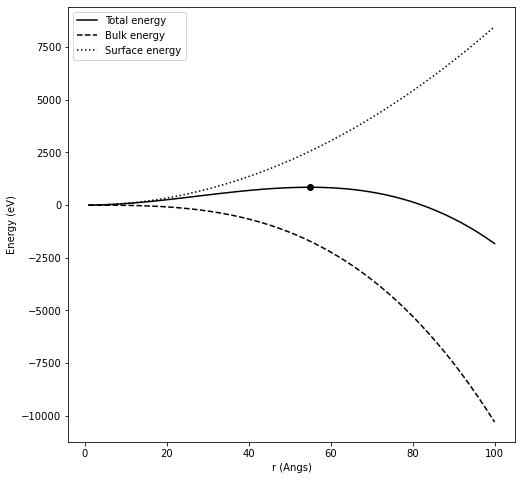

In [11]:
fig, ax = fig, ax = plt.subplots(figsize=(8,8))

ax.plot(r*1.0E10, delta_g*6.242e+18, 'k-', label='Total energy')
ax.plot(r*1.0E10, g_bulk_change*6.242e+18, 'k--', label='Bulk energy')
ax.plot(r*1.0E10, g_surface*6.242e+18, 'k:', label='Surface energy')
ax.plot(rc*1.0E10, gc*6.242e+18, 'ko')
ax.legend()
ax.set_xlabel('r (Angs)')
ax.set_ylabel('Energy (eV)')
plt.show()

In [12]:
for rtot in np.linspace(250.0E-10, 2500.0E-10, 10):
    rc, gc, xc = restricted_nucleation(x, p, t, gamma, rtot)
    print("Confinement radius:", rtot*1E10, "A. critical radius:", rc*1E10, 
          "A. energy barrier:", gc*6.242e+18, 'eV, final composition (mol frac Fe):', xc)

gsl  = well_mixed_gsl(x, p, t)
rc, gc = well_mixed_nucleation(gamma, np.array([gsl]))
print("Well mixed critical radius:", rc[0]*1E10, "A. Well mixed barrier:", gc[0]*6.242e+18, 'eV')

Confinement radius: 250.0 A. critical radius: 57.186599302665385 A. energy barrier: 884.0322066549403 eV, final composition (mol frac Fe): 0.8986936747791856
Confinement radius: 500.0 A. critical radius: 55.09632096058624 A. energy barrier: 853.6056976160365 eV, final composition (mol frac Fe): 0.8998556435382393
Confinement radius: 750.0 A. critical radius: 54.92017826179427 A. energy barrier: 850.9089490603429 eV, final composition (mol frac Fe): 0.8999576797970457
Confinement radius: 1000.0 A. critical radius: 54.878042506543515 A. energy barrier: 850.2607955205686 eV, final composition (mol frac Fe): 0.8999821915906004
Confinement radius: 1250.0 A. critical radius: 54.86310650524622 A. energy barrier: 850.0307493586528 eV, final composition (mol frac Fe): 0.8999908903294993
Confinement radius: 1500.0 A. critical radius: 54.856511564721075 A. energy barrier: 849.9291944859676 eV, final composition (mol frac Fe): 0.8999947303031824
Confinement radius: 1750.0 A. critical radius: 54.85

**Conclusions:**

In principle we could have a situation where the liquid around the nucleus becomes enriched in O.
This leads to a modificaton to CNT because we can no longer write $g^{sl}$ independent of $r$. However,
at least in this case adding O to the liquid make the liquid after creating the Fe solid less stable.
This increases the barrier height (by an amount that depends on the confinment radius). 

However, the sign of this effect should depend on the relative magnitude of the chemical potentials of 
Fe and O in the liquid. If (for example) we were nucleating FeO (and increasing the Fe content of the
residual liquid) the effect would lower the ovrall barrier to diffusion. 

None of this helps us escape the nucleation paradox (for the inner core or for a snow zone). However, 
I suspect this will be important to deal with nucleleation of oxide phases in the core (precipitation)
and could help us understand atomic scale simulations with impurities. 